# Variational AutoEncoder with PyTorch

- Written by Mark Mintae Kim
- PyTorch 1.9.1 / CUDA 10.2 / Python 3.8 
- 07/22/2022

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False, download=True, transform=transform)

/home/ados/anaconda3/envs/torch191/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 8
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Visualization

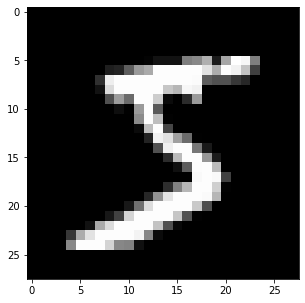

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Variational AutoEncoder

In [5]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [7]:
class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var * epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        
        return x_hat, mean, log_var 

In [8]:
encoder = Encoder(input_dim=784, hidden_dim=400, latent_dim=200)
decoder = Decoder(latent_dim=200, hidden_dim=400, output_dim=784)

model = VAE(Encoder=encoder, Decoder=decoder).to(device)

## Training

In [9]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=1e-3)

In [10]:
print("Start training VAE...")
model.train()

for epoch in range(20):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, 784)
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete", "\tAverage Loss: ", overall_loss / (batch_idx * batch_size))
    
print("Finish")

Start training VAE...
	Epoch 1 complete 	Average Loss:  151.2996107914878
	Epoch 2 complete 	Average Loss:  119.65733361112233
	Epoch 3 complete 	Average Loss:  114.92178822384155
	Epoch 4 complete 	Average Loss:  112.74212749668183
	Epoch 5 complete 	Average Loss:  111.403714462438
	Epoch 6 complete 	Average Loss:  110.47663974946401
	Epoch 7 complete 	Average Loss:  109.73881169211352
	Epoch 8 complete 	Average Loss:  109.23056339824863
	Epoch 9 complete 	Average Loss:  108.76706285518024
	Epoch 10 complete 	Average Loss:  108.30021640921322
	Epoch 11 complete 	Average Loss:  108.00084083610552
	Epoch 12 complete 	Average Loss:  107.714970525657
	Epoch 13 complete 	Average Loss:  107.35851665520994
	Epoch 14 complete 	Average Loss:  107.24034885611285
	Epoch 15 complete 	Average Loss:  107.0084216854023
	Epoch 16 complete 	Average Loss:  106.80177821521562
	Epoch 17 complete 	Average Loss:  106.66049937992025
	Epoch 18 complete 	Average Loss:  106.50547941232689
	Epoch 19 complete 	A

## Result

In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, 784)
        x = x.to(device)        
        x_hat, _, _ = model(x)
        break

  0%|          | 0/500 [00:00<?, ?it/s]


In [12]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

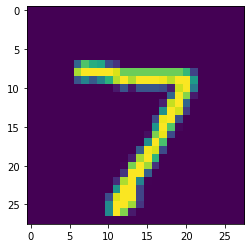

In [13]:
show_image(x, idx=0)

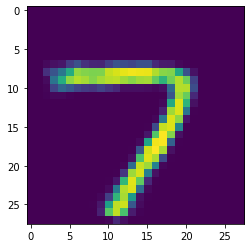

In [14]:
show_image(x_hat, idx=0)

## Generation from noise


In [15]:
with torch.no_grad():
    noise = torch.randn(batch_size, 200).to(device)
    generated_images = decoder(noise)

    
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

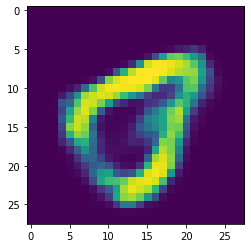

In [16]:
show_image(generated_images, idx=12)

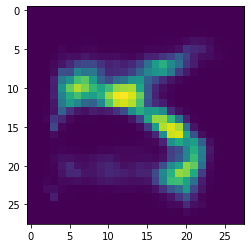

In [17]:
show_image(generated_images, idx=0)

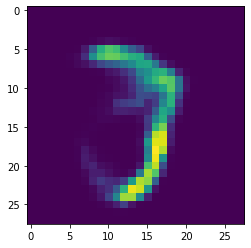

In [18]:
show_image(generated_images, idx=1)